In [1]:
# @title Get meteorologic model coordinates

import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/distan_lat42.58lon-8.8046p3R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [5]:
# @title Wind direction resample. Old and new fashion

from pandas.core.arrays import categorical
import math
from scipy.stats import entropy

def average_wind_direction(directions):
    if len(directions) == 0:
        return float('nan')
    total = 0
    for direction in directions:
        direction = direction % 360
        if direction > 180:
            direction = direction - 360
        total += direction
    average = total / len(directions)
    if average < 0:
        average = average + 360
    return average

#get station data
station_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/station_data/coron.csv", usecols = ["time","dir_o"],parse_dates=["time"]).set_index("time")
print(station_raw.info())

#delete duplicated
station = station_raw[~station_raw.index.duplicated(keep='first')]

#labels and intervals
interval=pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                       (60,80),(80,100),(100,120),(120,140),(140,160),
                                       (160,180),(180,200),(200,220),(220,240),
                                       (240,260),(260,280),(280,300),(300,320),
                                       (320,340),(340,360)])
labels=['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]', '(100, 120]',
        '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]', '(200, 220]',
        '(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]','(300, 320]',
        '(320, 340]', '(340, 360]']

#resample old fashion
station_o = station.resample("H",label="right",closed="right").mean()

station_o["dir_o_l_old"] = pd.cut(station_o["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_o = station_o.drop(["dir_o"],axis=1)

#resample new fashion
station_n = station.resample("H",label="right",closed="right").agg({'dir_o': average_wind_direction})
station_n["dir_o_l_new"] = pd.cut(station_n["dir_o"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station_n = station_n.drop(["dir_o"],axis=1)

#concatenate
station_dir_o = pd.concat([station_n,station_o],axis=1)

#Climatologies old and new
different_values_count = (station_dir_o['dir_o_l_new'] != station_dir_o['dir_o_l_old']).sum()
print("Climatology old and new resample. Differences between both: {:.0%}".format(different_values_count/len(station_dir_o)))
cli_o = station_dir_o["dir_o_l_old"].value_counts(normalize=True)
cli_n = station_dir_o["dir_o_l_new"].value_counts(normalize=True)
cli = pd.concat([cli_o, cli_n], axis=1, keys=['dir_o_l_old', 'dir_o_l_new'])
entro = pd.DataFrame(entropy(cli,base=2)/(math.log2(cli.shape[0])),columns=["entropy/entropy.max"],
                    index=cli.columns).T
display(pd.concat([cli,entro]).style.format('{:.0%}'))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262224 entries, 2018-01-01 00:10:00 to 2022-12-31 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dir_o   259014 non-null  float64
dtypes: float64(1)
memory usage: 4.0 MB
None
Climatology old and new resample. Differences between both: 19%


,dir_o_l_old,dir_o_l_new
"(40, 60]",21%,23%
"(200, 220]",13%,12%
"(20, 40]",12%,14%
"(180, 200]",10%,5%
"(220, 240]",8%,7%
"(60, 80]",6%,6%
"(240, 260]",5%,6%
"(160, 180]",5%,1%
"(260, 280]",4%,4%
"(80, 100]",3%,2%


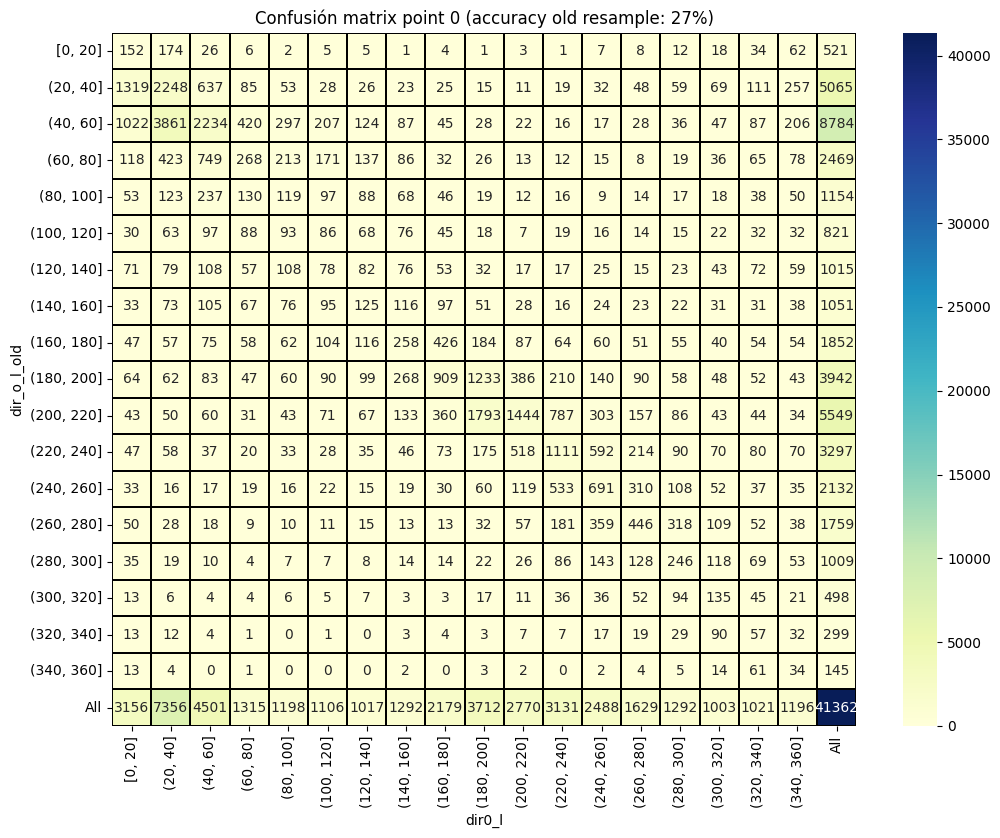

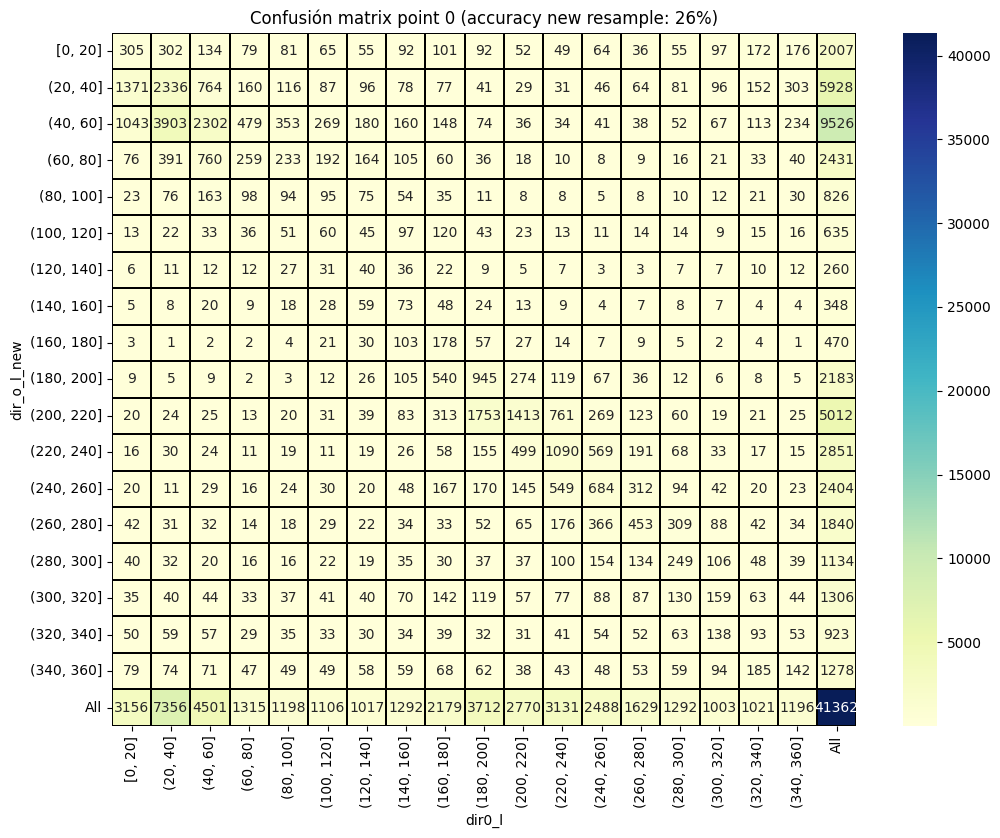

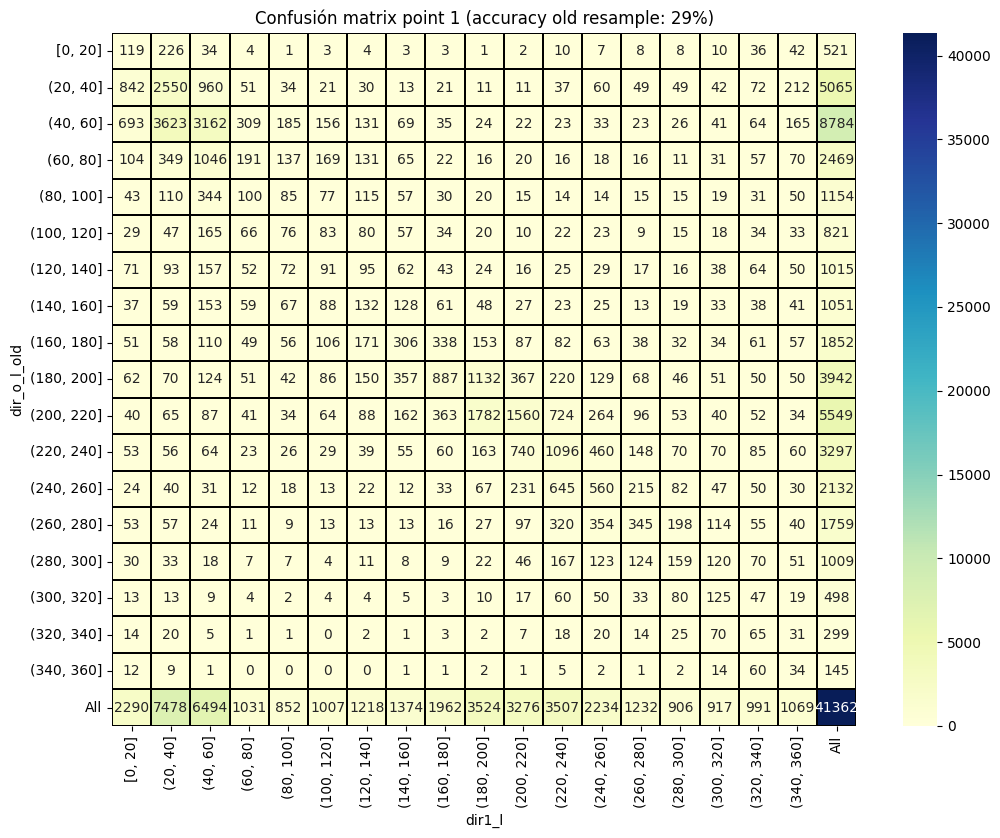

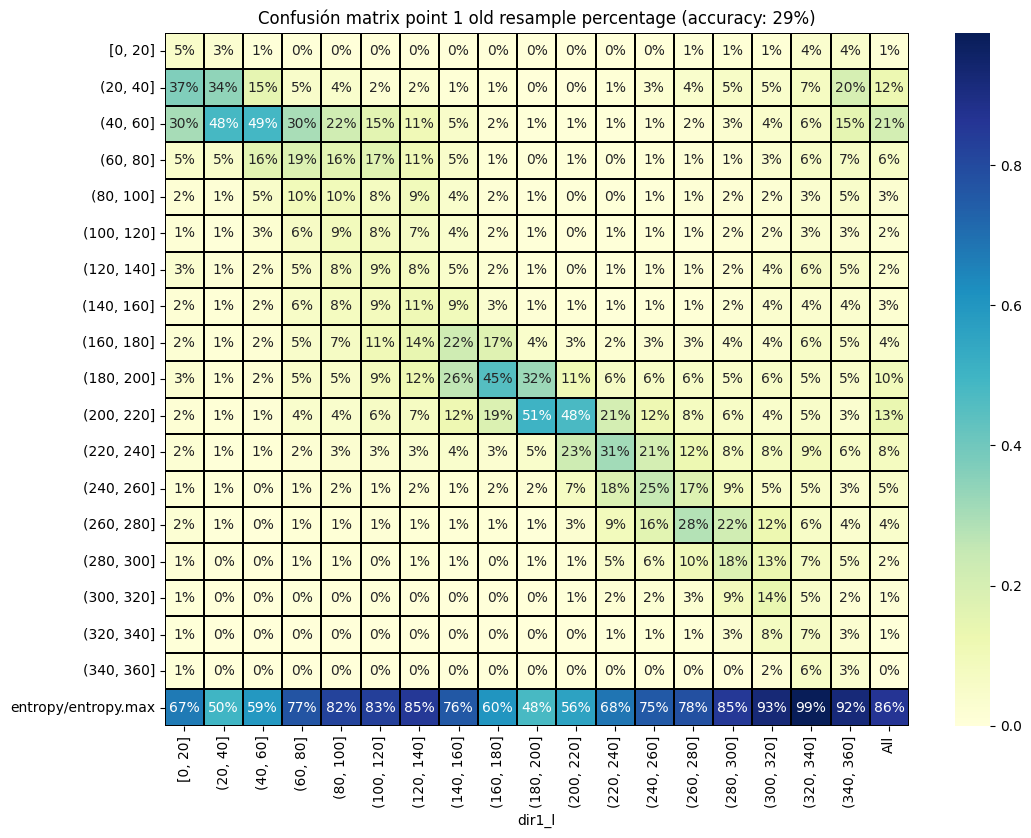

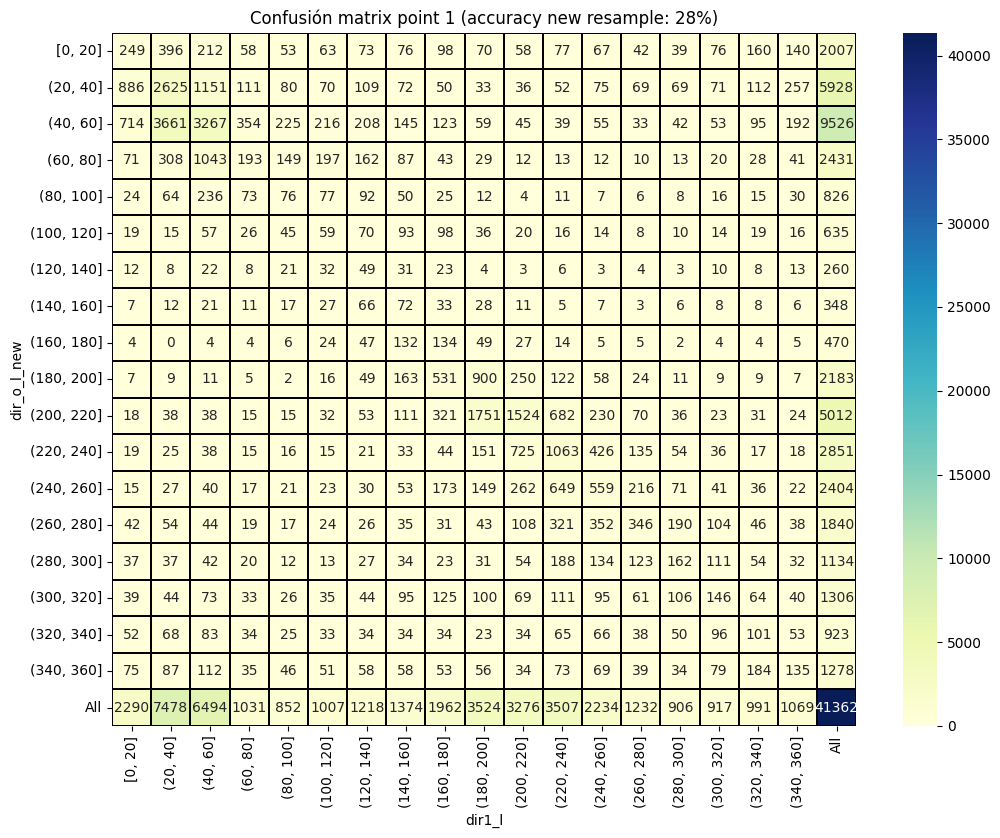

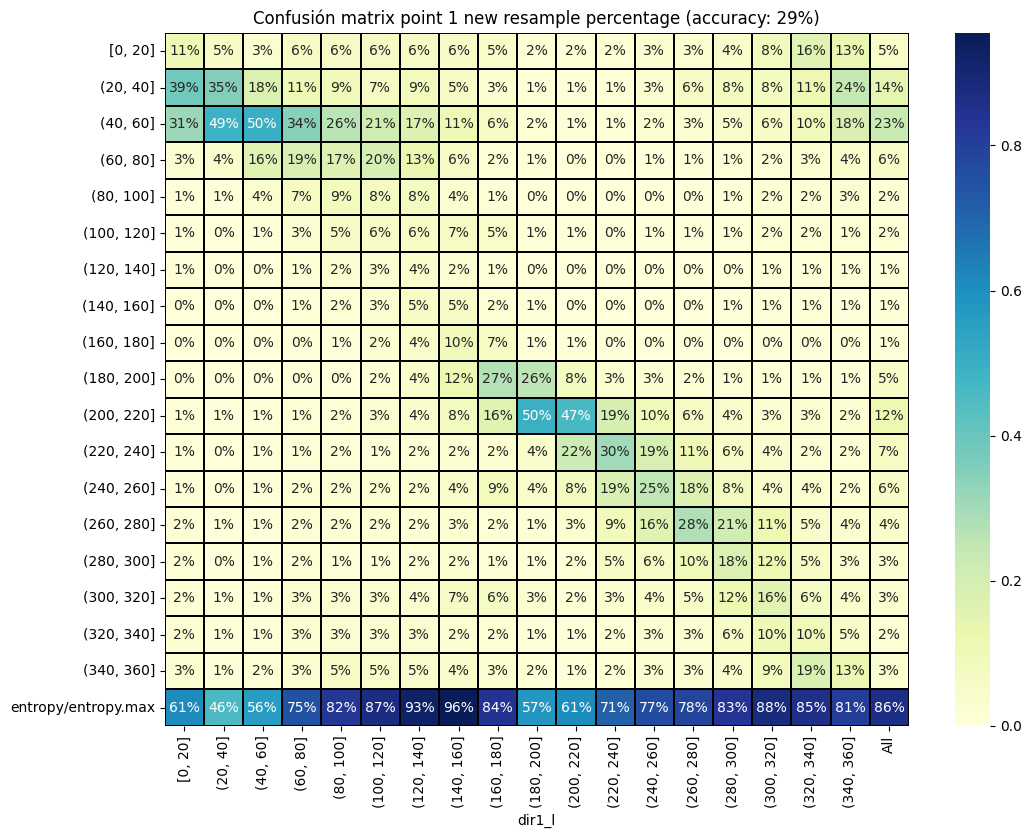

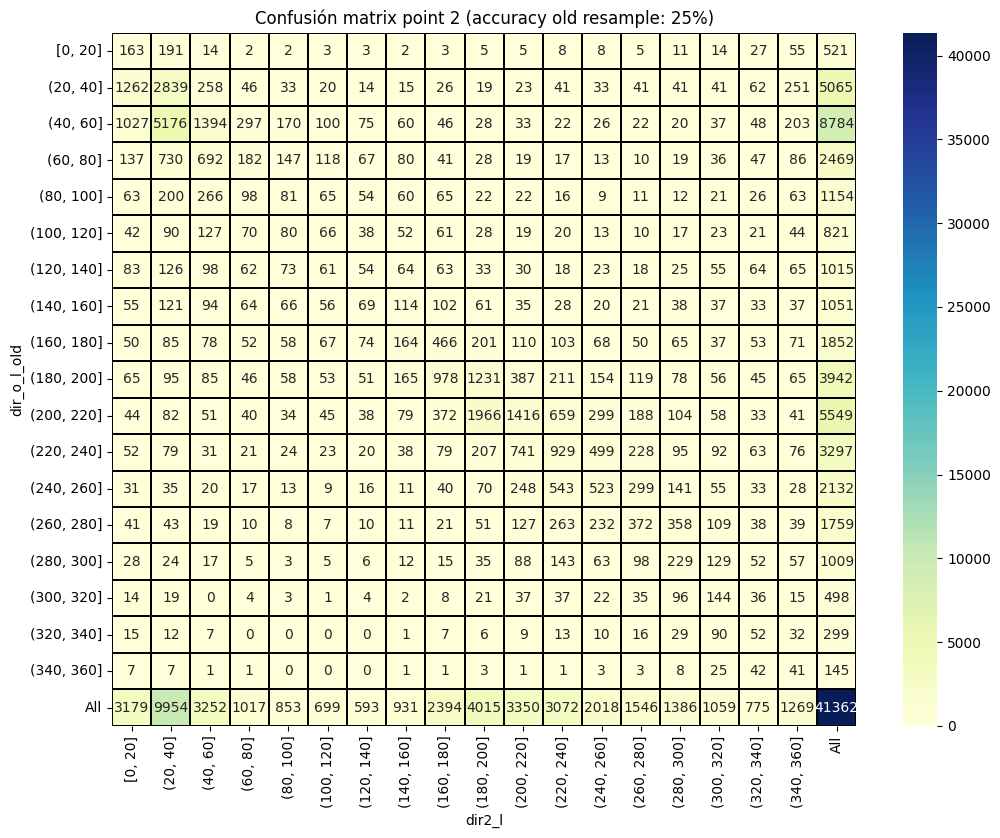

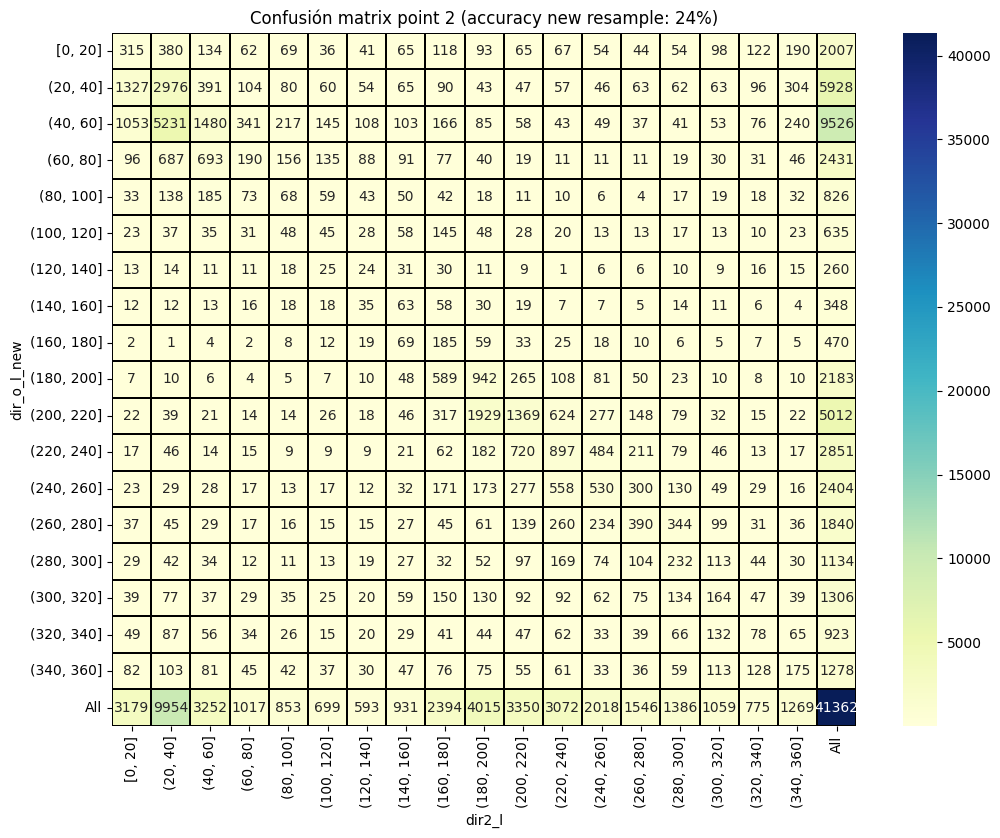

In [6]:
# @title Get meteorological model and compare with wind direction old and new resample method

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#ria forecast d0
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Coron/met_ model/lat42.58lon-8.8046p3R4KmD0.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")

#concatenate with station and dropna
df_all = pd.concat([station_dir_o,met_model],axis=1).dropna()

#label model
df_all["dir0_l"] = pd.cut(df_all["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir1_l"] = pd.cut(df_all["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir2_l"] = pd.cut(df_all["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

#get accuracy and display confusion matrix
acc0_old = accuracy_score(df_all.dir_o_l_old, df_all.dir0_l)
acc0_new = accuracy_score(df_all.dir_o_l_new, df_all.dir0_l)
acc1_old = accuracy_score(df_all.dir_o_l_old, df_all.dir1_l)
acc1_new = accuracy_score(df_all.dir_o_l_new, df_all.dir1_l)
acc2_old = accuracy_score(df_all.dir_o_l_old, df_all.dir2_l)
acc2_new = accuracy_score(df_all.dir_o_l_new, df_all.dir2_l)

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy old resample: {:.0%})".format(acc0_old))
global_sc = pd.crosstab(df_all.dir_o_l_old, df_all.dir0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy new resample: {:.0%})".format(acc0_new))
global_sc = pd.crosstab(df_all.dir_o_l_new, df_all.dir0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy old resample: {:.0%})".format(acc1_old))
global_sc = pd.crosstab(df_all.dir_o_l_old, df_all.dir1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

#in % and entropy
columns_sc = pd.crosstab(df_all.dir_o_l_old, df_all.dir1_l, margins=True, normalize="columns")
entro = pd.DataFrame(entropy(columns_sc,base=2)/(math.log2(columns_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=columns_sc.columns).T
columns_entro = pd.concat([columns_sc,entro])
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 old resample percentage (accuracy: {:.0%})".format(acc1_old))
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy new resample: {:.0%})".format(acc1_new))
global_sc = pd.crosstab(df_all.dir_o_l_new, df_all.dir1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

#in % and entropy
columns_sc = pd.crosstab(df_all.dir_o_l_new, df_all.dir1_l, margins=True, normalize="columns")
entro = pd.DataFrame(entropy(columns_sc,base=2)/(math.log2(columns_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=columns_sc.columns).T
columns_entro = pd.concat([columns_sc,entro])
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 new resample percentage (accuracy: {:.0%})".format(acc1_old))
sns.heatmap(columns_entro,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy old resample: {:.0%})".format(acc2_old))
global_sc = pd.crosstab(df_all.dir_o_l_old, df_all.dir2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy new resample: {:.0%})".format(acc2_new))
global_sc = pd.crosstab(df_all.dir_o_l_new, df_all.dir2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
Accuracy Machine learning models


,acc_t
count,1.000000e+01
mean,4.400000e-01
std,5.851389e-17
min,4.400000e-01
25%,4.400000e-01
50%,4.400000e-01
75%,4.400000e-01
max,4.400000e-01


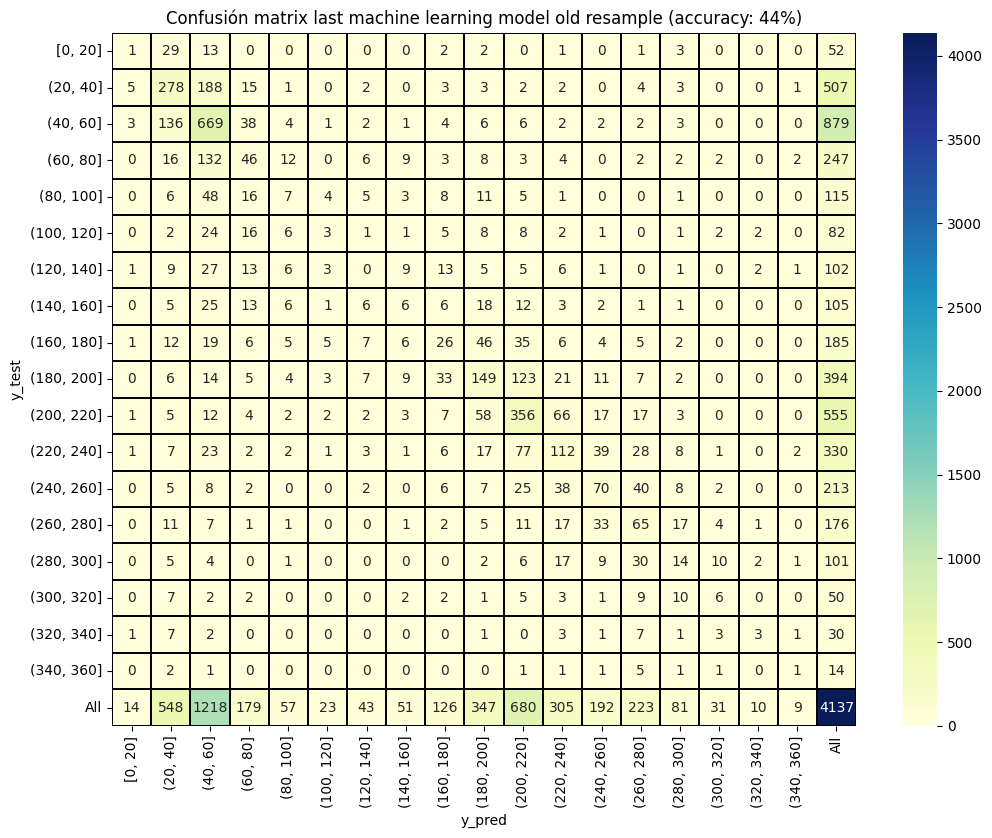

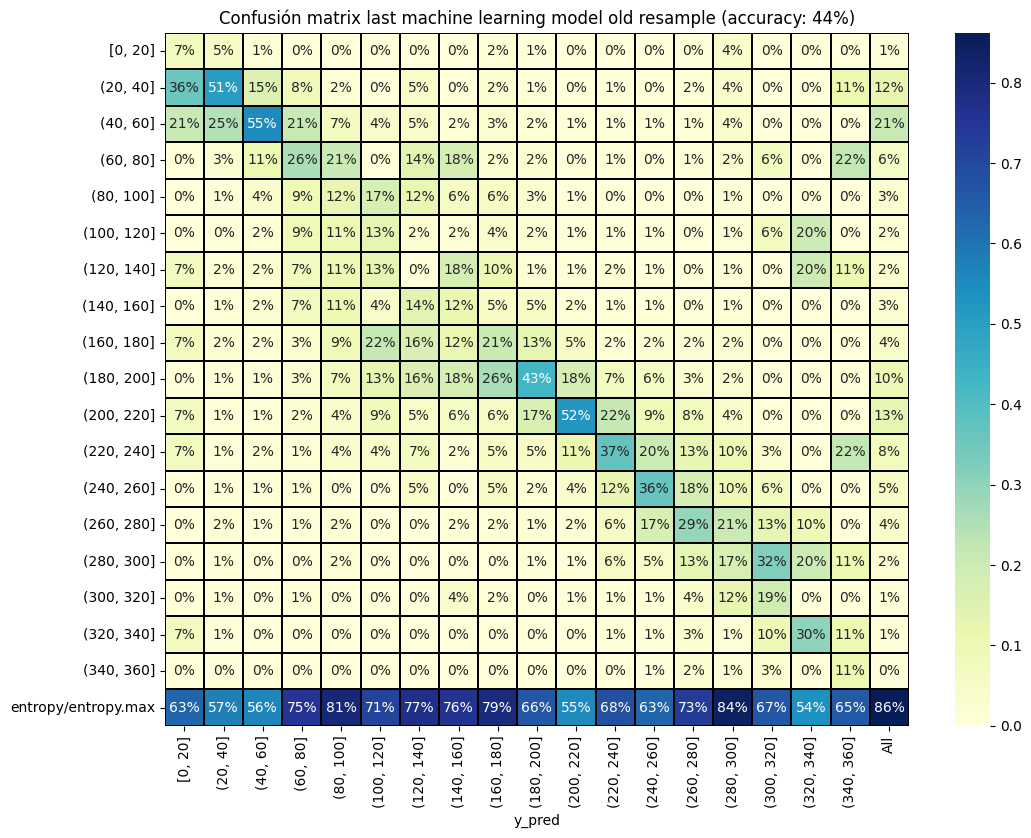

In [7]:
# @title Machine learning algorithm show results old resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l_old
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=1, stratify=Y )
  ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))

print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

y_pred_serie =pd.Series(y_pred,index=y_test.index)
df_test = pd.concat([y_test, y_pred_serie], axis=1, keys=['y_test', 'y_pred'])

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model old resample (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True,)
lab = labels+["All"]
sns.heatmap(global_sc[lab],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

columns_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True, normalize="columns")
entro = pd.DataFrame(entropy(columns_sc,base=2)/(math.log2(columns_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=columns_sc.columns).T
columns_entro = pd.concat([columns_sc,entro])
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model old resample (accuracy: {:.0%})".format(acc_t[-1]))
sns.heatmap(columns_entro[lab],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');



In [19]:
!pip freeze > requirements.txt

machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
Accuracy Machine learning models


,acc_t
count,10.000000
mean,0.435000
std,0.009718
min,0.420000
25%,0.430000
50%,0.430000
75%,0.440000
max,0.450000


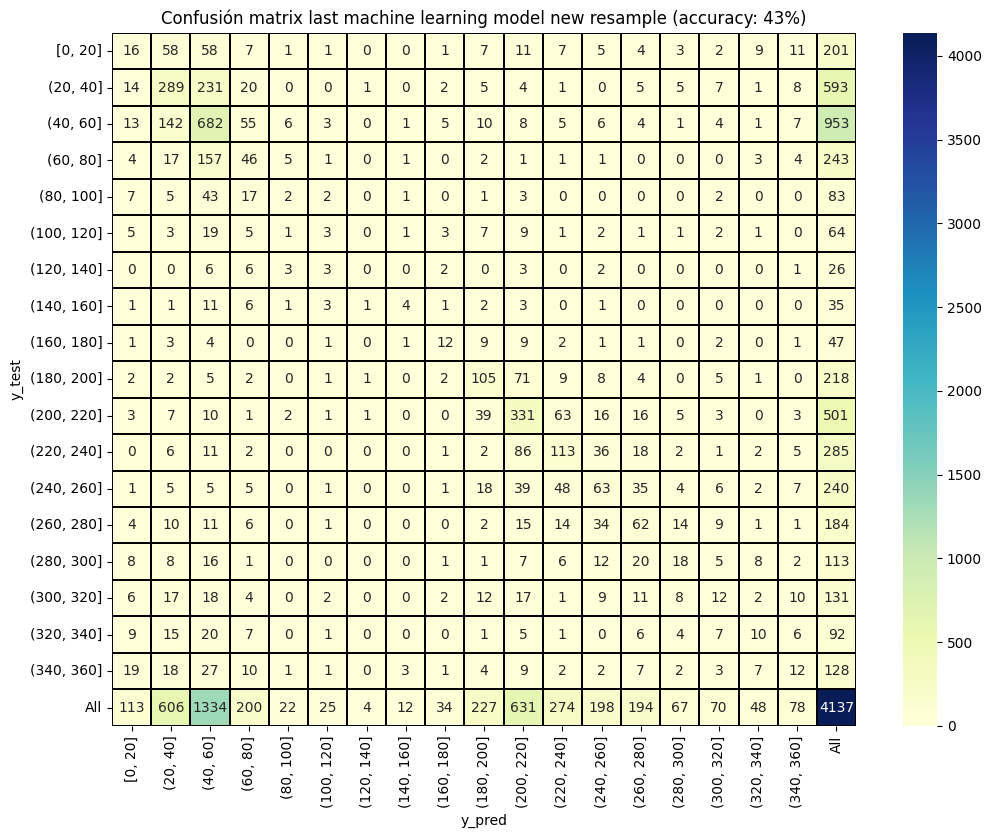

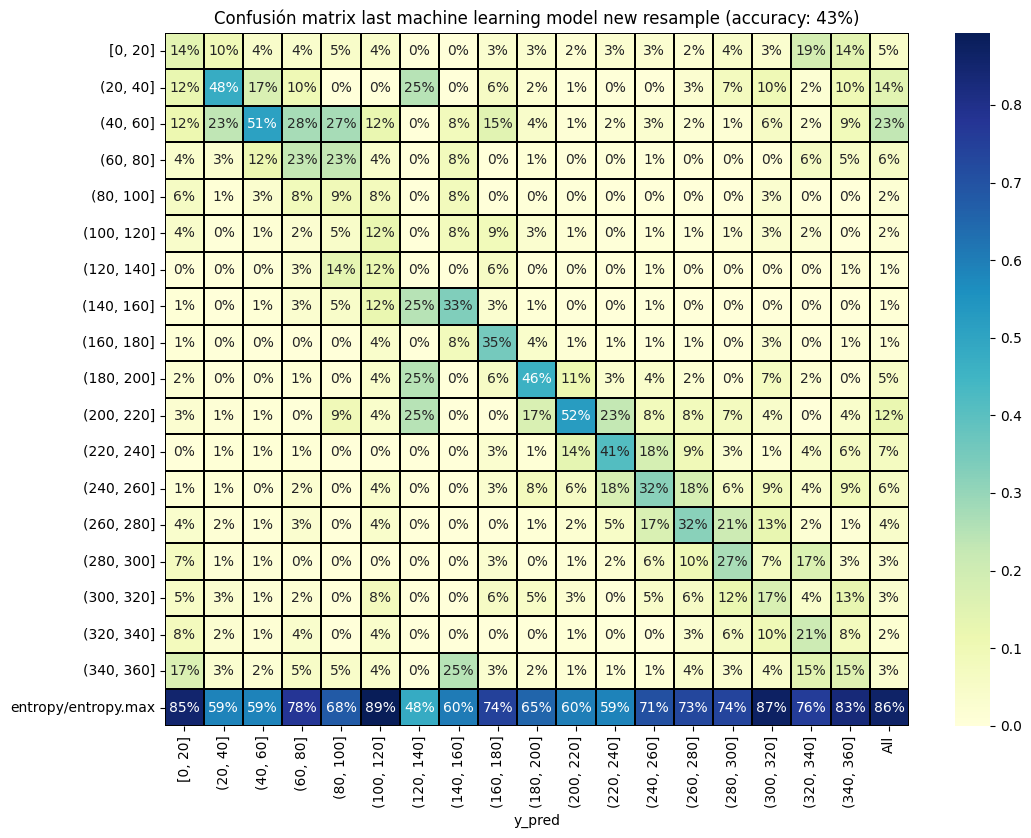

In [ ]:
# @title Machine learning algorithm LGBMClassifier show results new resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l_new
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y,)
  ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train,)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))

print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

y_pred_serie =pd.Series(y_pred,index=y_test.index)
df_test = pd.concat([y_test, y_pred_serie], axis=1, keys=['y_test', 'y_pred'])

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model new resample (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True,)
lab = labels+["All"]
sns.heatmap(global_sc[lab],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

columns_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True, normalize="columns")
entro = pd.DataFrame(entropy(columns_sc,base=2)/(math.log2(columns_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=columns_sc.columns).T
columns_entro = pd.concat([columns_sc,entro])
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model new resample (accuracy: {:.0%})".format(acc_t[-1]))
sns.heatmap(columns_entro[lab],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

In [ ]:
# @title Save last Machine learning algorithm and score of new resample

import pickle
from sklearn.pipeline import Pipeline

score ={"acc_met":round(acc1_new,2),"acc_ml":acc_t[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Coron/algorithms/dir_coron_d0.al", 'wb'))

Pipeline(steps=[('ml_model',
                 LGBMClassifier(force_col_wise=True, n_estimators=200,
                                verbose=0))])


machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
Accuracy Machine learning models


,acc_t
count,10.000000
mean,0.435000
std,0.008498
min,0.420000
25%,0.430000
50%,0.435000
75%,0.440000
max,0.450000


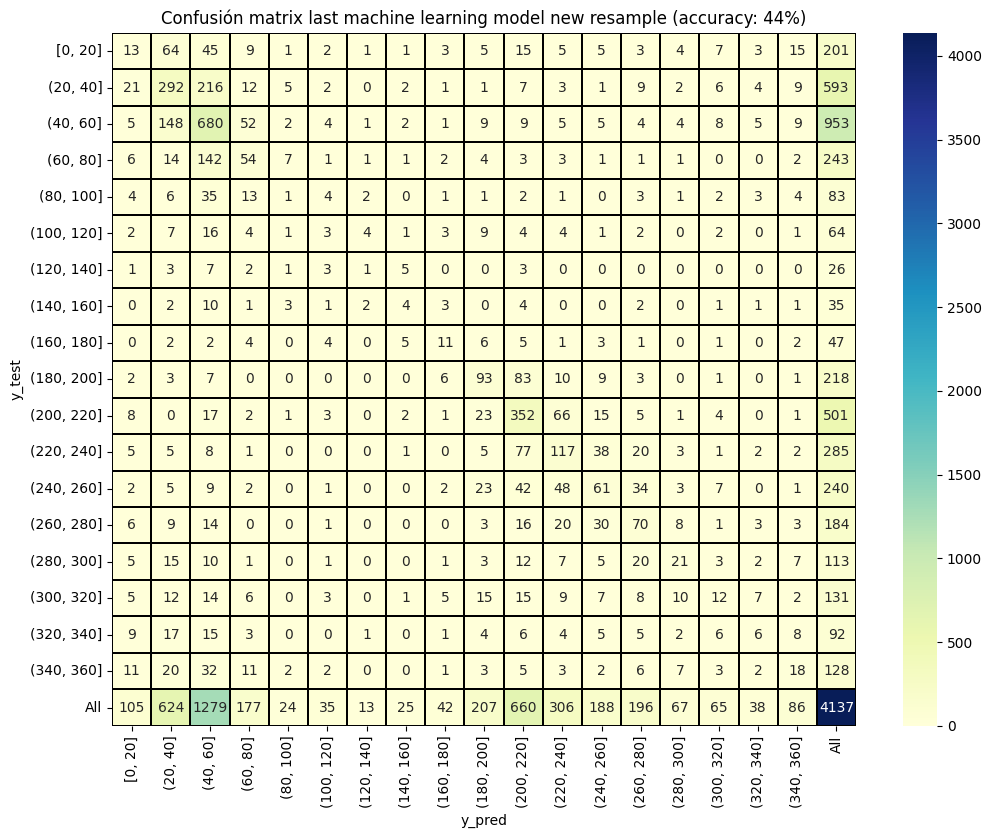

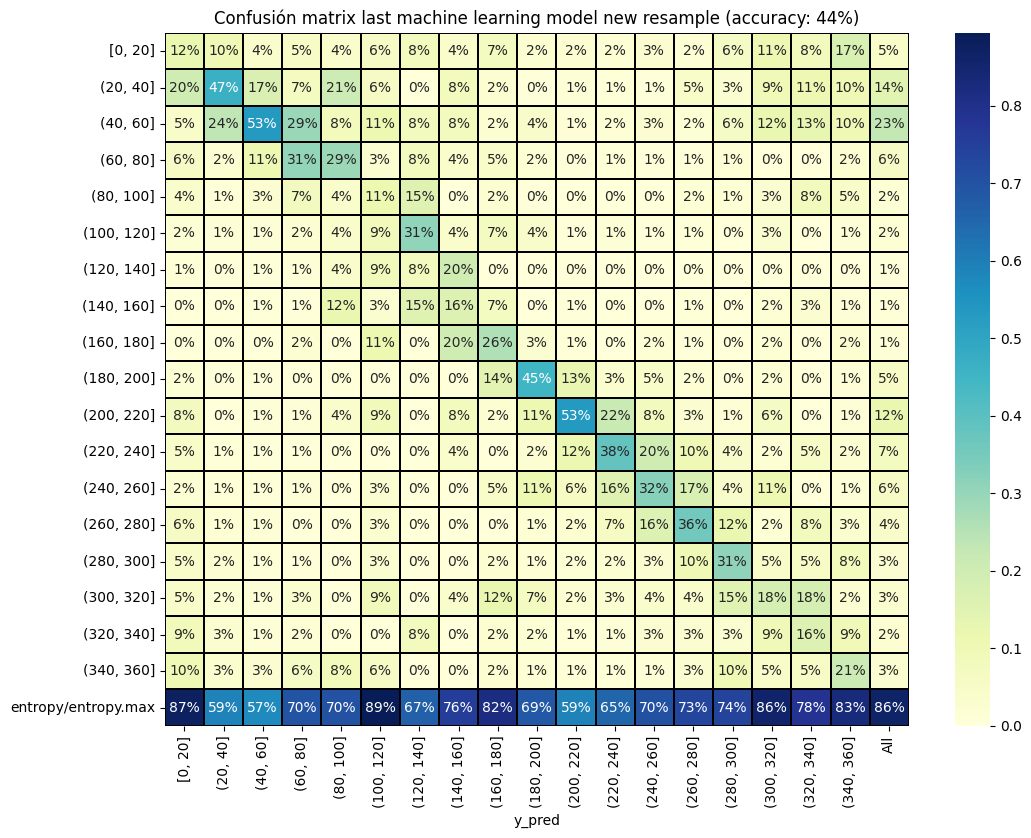

In [ ]:
# @title Machine learning algorithm extratrees show results new resample


#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l_new
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,10):
  print("machine learning number:",t)
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1,stratify=Y,)
  #ml_model = LGBMClassifier(n_estimators=200,verbose=0,force_col_wise=True).fit(X_train,y_train,)
  ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))

print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
display(df_r.describe())

y_pred_serie =pd.Series(y_pred,index=y_test.index)
df_test = pd.concat([y_test, y_pred_serie], axis=1, keys=['y_test', 'y_pred'])

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model new resample (accuracy: {:.0%})".format(acc_t[-1]))
global_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True,)
lab = labels+["All"]
sns.heatmap(global_sc[lab],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

columns_sc = pd.crosstab(df_test.y_test, df_test.y_pred, margins=True, normalize="columns")
entro = pd.DataFrame(entropy(columns_sc,base=2)/(math.log2(columns_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=columns_sc.columns).T
columns_entro = pd.concat([columns_sc,entro])
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model new resample (accuracy: {:.0%})".format(acc_t[-1]))
sns.heatmap(columns_entro[lab],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');